## Workflow
- profile and registered
- ccfed
- bouton filter
- bouton_swc pruning
- bouton_feature: FileIO-func2
- bouton distribution in branch: NeuroMorphoLib-bouton_distribution
- bouton branch feature: NeuroMorphoLib-branch_feature-0,0,1
### venv
- bouton_ana
- python3.9.18

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import math
import os
from pandas.plotting import parallel_coordinates
import sklearn
from scipy.sparse.csgraph import minimum_spanning_tree
from sklearn.preprocessing import StandardScaler
from matplotlib.ticker import MaxNLocator
from math import pi

plt.style.use(['science', 'no-latex'])


TH=['AD','AM','AV','CL','CM','IAD','LD','LGd','LHA','LP','MD','MG','MM','PCN','PF','PIL','PO','POL','PR','PVT',
   'PoT','RE','RT','SGN','SMT','TH','VAL','VM','VPL','VPLpc','VPM','VPMpc']
CTX=['ACAd','ACAv','AId','AIp','AIv','AON','AON','AUDd','AUDpo','AUDv','BLA','BMA','CA1','CA3','CLA','COAp','HPF','DG',
    'ECT','ENTl','ENTm','EPd','FRP','GU','IG','ILA','MOB','MOp','MOs','ORBl','ORBm','ORBvl','PIR','PL','POST','PRoS',
    'RSPagl','RSPd','RSPv','SSs','SUB','TEa','TR','VISC','VISa','VISal','VISam','VISl','VISli','VISp','VISpm',
    'VISpor','VISrl','SSp','SSp-bfd','SSp-ll','SSp-m','SSp-n','SSp-tr','SSp-ul','SSp-un','AUDp','PAA','ProS']
CNU=['ACB','BST','CEA','CP','FS','GPe','GPi','LSr','LSv','OT','PAL','PAR','PRE','SI','NDB','AAA']
HY=['AHN','DMH','HY','PH','PSTN','PVH','PVi','PeF','SBPV','TU','VMH','ZI']
CB=['CENT','COPY','CUL','DEC','FL','FN','FOTU','NOD','PFL','AN','PRM','PYR','SIM']
MB=['DR','IC','MB','MRN','MV','MY','PAG','RN','SNc']
HB=['IRN','LRN','MDRNd','MDRNv','P','PARN','PB','PG','PGRNl','PRNc','PRNr','PSV','SPIV','SPVC','SPVO','SUV','TRN','V','VCO']
btype=['CNU','TH','CTX']
bcolors=['#75bbfd','#029386','#ff796c']
cnu_stypes=['CP','OT']
th_stypes=['VPM','VPL','LGd','LP','VPLpc','MG', 'RT']
ctx_stypes=['MOp', 'MOs','SSp','SSs','AId', 'RSPv', 'CLA']
ana_regions=['CP','OT','VPM','VPL','LGd','LP','VPLpc','MG', 'RT','SSp','SSp-bfd','SSp-ul','SSp-ll','SSp-m','SSp-n', 'SSp-un','MOp', 'MOs','SSs', 'AId', 'RSPv', 'CLA']
ana_stypes=['CP','OT','VPM','VPL','LGd','LP','VPLpc','MG', 'RT','SSp','MOp', 'MOs','SSs', 'AId', 'RSPv', 'CLA']
ssp_regions=['SSp','SSp-bfd','SSp-ul','SSp-ll','SSp-m','SSp-n', 'SSp-un']
morpho_feas=pd.read_csv('../fullmorpho/py/ana_lm_statistics_full.csv',index_col=['name'])
usedfeas=['type','x','y','z','radius','parent','level']
swc_fea_list=['ccfx','ccfy','ccfz','ccfr','btype','bdist','neighborb','dist2soma','edist2soma','nearbdist','node_contraction']
sheader=['##n','type','x','y','z','radius','parent','bdist','neighborb','dist2soma','edist2soma','nearbdist','node_contraction']
rheader=['n','type','x','y','z','radius','parent','bdist','neighborb','dist2soma','edist2soma','nearbdist','node_contraction']
bswcdata='./bfeas'
out_fea_path='ccf_bfea'

In [2]:
def saveswc(inswc,tofile,scale=1,retype=None,xshift=0,flip=False,header=None):
    swc=inswc.copy()
    if header is None:
        header=['##n','type','x','y','z','radius','parent']
    if retype is not None:
        swc['type']=retype
    if scale != 1 and scale >0:
        swc['x']/=scale
        swc['y']/=scale
        swc['z']/=scale
        if xshift:
            swc['x']+=xshift
        soma=swc[swc.parent<0].copy()
        soma=soma.iloc[0]
        sz=soma['z']
        if flip and sz > 456/2:
            # print('flip')
            swc['z']= 456 - swc['z']
    swc.reset_index(inplace=True)
    if swc.shape[1] != len(header):
        print('Input SWC header not match!!!')
        header=swc.keys().to_list()
        header[0]='##'+header[0]
    swc.to_csv(tofile,sep=' ',index=0,header=header)
    # return swc
def get_degree(tswc):
    tswc['degree'] = tswc['parent'].isin(tswc.index).astype('int')
    # print(tswc['degree'])
    n_child = tswc.parent.value_counts()
    n_child = n_child[n_child.index.isin(tswc.index)]
    tswc.loc[n_child.index, 'degree'] = tswc.loc[n_child.index, 'degree'] + n_child
    return tswc
def get_rid(swc):
    '''
    Find root node.
    '''
    rnode=swc[((swc['parent']<0) & (swc['type']<=1))]
    if rnode.shape[0]<1:
        return -1
    return rnode.index[0]
def get_keypoint(inswc, rid=None):
    swc=inswc.copy()
    if rid is None:
        rid = get_rid(swc)
    #print(swc.shape)
    swc=get_degree(swc)
    idlist = swc[((swc.degree!=2) | (swc.index==rid))].index.tolist()
    return idlist
def swc2branches(swc):
    '''
    reture branch list of a swc
    branch: down to top
    '''
    keyids=get_keypoint(swc)
    branches=[]
    for key in keyids:
        if swc.loc[key,'parent']<0 | swc.loc[key,'type']<=1:
            continue
        branch=[]
        branch.append(key)
        pkey=swc.loc[key,'parent']
        while True:
            branch.append(pkey)
            if pkey in keyids:
                break
            key=pkey
            pkey=swc.loc[key,'parent']
        branches.append(branch)
    return branches
def get_tips(swc, rid=None, ntype = None):
    if rid is None:
        rid = get_rid(swc)
    #print(swc.shape)
    swc=get_degree(swc)
    if ntype is not None:
        idlist = swc[(swc.degree<2) & (swc.type == ntype) ].index.tolist()
    else:
        idlist = swc[(swc.degree<2)].index.tolist()
    return idlist
def get_brpoints(swc, rid=None, ntype=None):
    if rid is None:
        rid = get_rid(swc)
    #print(swc.shape)
    swc=get_degree(swc)
    if ntype is not None:
        idlist = swc[((swc.degree>2) & (swc.index!=rid) & (swc.type == ntype))].index.tolist()
    else:
        idlist = swc[((swc.degree>2) & (swc.index!=rid))].index.tolist()
    return idlist
def nodes_dis(swc,n1,n2):
    if n1 not in swc.index or n2 not in swc.index:
        return None
    x1=swc.loc[n1,'x']
    y1=swc.loc[n1,'y']
    z1=swc.loc[n1,'z']
    x2=swc.loc[n2,'x']
    y2=swc.loc[n2,'y']
    z2=swc.loc[n2,'z']
    return math.sqrt((x1-x2)*(x1-x2)+(y1-y2)*(y1-y2)+(z1-z2)*(z1-z2))
def readswc(file,out_fea=None,fea_val_names=None,header=None,skiprows=3):
    swc=pd.read_csv(file,sep=' ',header=None,skiprows=skiprows)
    if header is None:
        header=['n','type','x','y','z','radius','parent']
        if swc.shape[1] >= 12:
            header+=['seg_id','level','mode','timestamp','teraflyindex']
            for i in np.arange(12,swc.shape[1]):
                if fea_val_names is not None:
                    header.append(fea_val_names[i-12])
                else:
                    header.append('fea_'+str(i-12))
    if len(header) == swc.shape[1]:
        swc.columns=header
    swc.set_index(['n'],drop=True,inplace=True)
    if out_fea is None:
        return swc
    else:
        return swc[out_fea]
def bswc2ccf(inswc,scale=1,ignore_dendrite=False):
    if ignore_dendrite:
        swc=inswc[(inswc.type !=4) & (inswc.type !=3)].copy()
    else:
        swc=inswc.copy()
    swc=swc[['type','parent','ccfx', 'ccfy', 'ccfz', 'ccfr', 'btype',
       'bdist', 'neighborb', 'dist2soma', 'edist2soma','nearbdist','node_contraction']].copy()
    swc['x']=round(swc['ccfx']/scale,2)
    swc['y']=round(swc['ccfy']/scale,2)
    swc['z']=round(swc['ccfz']/scale,2)
    swc['r']=round(swc['ccfr']/scale,4)
    swc.loc[swc.btype==3,'type']=6
    swc['dist2soma']=round(swc['dist2soma'],2)
    swc['edist2soma']=round(swc['edist2soma'],2)
    swc['nearbdist']=round(swc['nearbdist'],2)
    swc['node_contraction']=round(swc['node_contraction'],4)
    return swc[['type','x', 'y', 'z', 'r','parent',
       'bdist', 'neighborb', 'dist2soma', 'edist2soma','nearbdist','node_contraction']]


### read featured bouton swc file and save to ccf-scale

In [10]:
for root,dirs,files in os.walk(bswcdata):
    for mfile in files:
        if mfile == '.DS_Store':
            continue
        file_in=os.path.join(root,mfile)
        file_out=os.path.join(out_fea_path,mfile)
        if os.path.exists(file_out):
            continue
        swc=readswc(file=file_in,
            out_fea=usedfeas+swc_fea_list,
            fea_val_names=swc_fea_list)
        rid=get_rid(swc=swc)
        if rid < 0:
            print('wrong file: ',mfile)
            continue
        cswc=bswc2ccf(swc,scale=25)
        saveswc(cswc,tofile=file_out,flip=True,header=sheader)

### get bouton features

In [4]:
# bnum, tebnum,bdist,dist2soma,edist2soma,nb,wire_raw,wire_effi,wire_bouton,wire_br,star
def point_dist(p1,p2):
    return math.sqrt(pow((p1['x']-p2['x']),2)+pow((p1['y']-p2['y']),2)+pow((p1['z']-p2['z']),2))
def get_swc_total_len(swc):
    total_len=0
    # if 'degree' not in swc.keys():
    #     get_degree(swc)
    for si in swc.index:
        if swc.loc[si,'parent'] not in swc.parent:
            continue
        s=swc.loc[si]
        sp=swc.loc[swc.loc[si,'parent']]
        total_len+=point_dist(s,sp)
    return total_len
def get_mst(inswc,neuron_len=None,idlist=None):
    swc=inswc.copy()
    if idlist is not None:
        swc=inswc.loc[idlist,:].copy()
    
    df = swc[['x', 'y', 'z']].dropna().copy()
    X = sklearn.metrics.pairwise_distances(df)
    Tcsr = minimum_spanning_tree(X).toarray()
    if neuron_len is None:
        neuron_len = get_swc_total_len(swc)
    wire_mst_len = np.sum(Tcsr)
    return wire_mst_len
def get_star_tree_length(inswc, rid=None,idlist=None):
    swc=inswc.copy()
    if idlist is not None:
        swc=inswc.loc[idlist,:].copy()
    if rid is None:
        rid = get_rid(swc)
    dis=0.0
    rp = swc.loc[rid]
    for si in swc.index:
        s=swc.loc[si]
        dis+=point_dist(s,rp)
    dis/=(swc.shape[0]-1)
    return dis
def bouton_features(inswc,neuron_len,rid=None,scale=1,basic=True):
    if not basic:
        if rid is None:
            rid = get_rid(inswc)
        keyids=get_keypoint(inswc,rid=rid)
        if not len(keyids):
            print('no key node')
            return None
        k_mst_len=get_mst(inswc=inswc,neuron_len=neuron_len,idlist=keyids)
        k_mst_len*=scale
        k_wire_effi=k_mst_len/neuron_len
        
        kstar_tree_len=get_star_tree_length(inswc=inswc,idlist=keyids,rid=rid)
        k_plen=inswc.loc[keyids,'dist2soma'].mean()
        kstar_tree_len*=scale
        k_tran_effi=kstar_tree_len/k_plen

        bids=inswc[(inswc.type==1)| (inswc.type>=5)].index.to_list()
        # print(len(bids))
        if not len(bids):
            print('no bouton node')
            return None
        b_mst_len=get_mst(inswc=inswc,neuron_len=neuron_len,idlist=bids)
        b_mst_len*=scale
        b_wire_effi=b_mst_len/neuron_len
        bstar_tree_len=get_star_tree_length(inswc=inswc,idlist=bids,rid=rid)
        b_plen=inswc.loc[bids,'dist2soma'].mean()
        bstar_tree_len*=scale
        b_tran_effi=bstar_tree_len/b_plen

    swc=inswc[inswc.type>=5].copy()
    bnum=swc.shape[0]
    tebratio=swc[swc.type==6].shape[0]/bnum
    ed2s_max=swc['edist2soma'].max()
    ed2s_min=swc['edist2soma'].min()
    ed2s_mean=swc['edist2soma'].mean()
    ed2s_std=swc['edist2soma'].std()
    pd2s_max=swc['dist2soma'].max()
    pd2s_min=swc['dist2soma'].min()
    pd2s_mean=swc['dist2soma'].mean()
    pd2s_std=swc['dist2soma'].std()
    binterval_max=swc['nearbdist'].max()
    binterval_min=swc['nearbdist'].min()
    binterval_mean=swc['nearbdist'].mean()
    binterval_std=swc['nearbdist'].std()
    bdist2pb_max=swc['bdist'].max()
    bdist2pb_min=swc['bdist'].min()
    bdist2pb_mean=swc['bdist'].mean()
    bdist2pb_std=swc['bdist'].std()
    neighborb_max=swc['neighborb'].max()
    neighborb_min=swc['neighborb'].min()
    neighborb_mean=swc['neighborb'].mean()
    neighborb_std=swc['neighborb'].std()
    bfeas=[bnum,tebratio,
            pd2s_max,pd2s_min,pd2s_mean,pd2s_std,
            ed2s_max,ed2s_min,ed2s_mean,ed2s_std,
            binterval_max,binterval_min,binterval_mean,binterval_std,
            bdist2pb_max,bdist2pb_min,bdist2pb_mean,bdist2pb_std,
            neighborb_max,neighborb_min,neighborb_mean,neighborb_std]
    if not basic:
        bfeas=[bnum,tebratio,
                pd2s_max,pd2s_min,pd2s_mean,pd2s_std,
                ed2s_max,ed2s_min,ed2s_mean,ed2s_std,
                binterval_max,binterval_min,binterval_mean,binterval_std,
                bdist2pb_max,bdist2pb_min,bdist2pb_mean,bdist2pb_std,
                neighborb_max,neighborb_min,neighborb_mean,neighborb_std,
                b_mst_len,bstar_tree_len,b_plen,b_wire_effi,b_tran_effi,
                k_mst_len,kstar_tree_len,k_plen,k_wire_effi,k_tran_effi]
    return bfeas
bfea_names=['bnum','tebratio',
            'pd2s_max','pd2s_min','pd2s_mean','pd2s_std',
            'ed2s_max','ed2s_min','ed2s_mean','ed2s_std',
            'binterval_max','binterval_min','binterval_mean','binterval_std',
            'bdist2pb_max','bdist2pb_min','bdist2pb_mean','bdist2pb_std',
            'neighborb_max','neighborb_min','neighborb_mean','neighborb_std',
            # 'b_mst_len','bstar_tree_len','b_plen','b_wire_effi','b_tran_effi',
            # 'k_mst_len','kstar_tree_len','k_plen','k_wire_effi','k_tran_effi'
            ]
raw_feas_file='ana_bouton_features.csv'
fromFile=True
if fromFile and os.path.exists(raw_feas_file):
    all_feas=pd.read_csv(raw_feas_file,index_col=['name'])
else:
    all_feas=pd.DataFrame(columns=bfea_names)
    for root,dirs,files in os.walk(out_fea_path):
        for mfile in files:
            if mfile == '.DS_Store':
                continue
            file_in=os.path.join(root,mfile)
            fname=mfile.split('.eswc')[0]
            if fname in all_feas.index:
                continue
            swc=readswc(file=file_in,header=rheader,skiprows=1)
            rid=get_rid(swc=swc)
            if rid < 0:
                print('wrong file: ',fname)
                continue
            if swc[swc.type>=5].shape[0]==0:
                print('no bouton: ',fname)
                continue
            bfeas=bouton_features(swc,neuron_len=morpho_feas.loc[fname,'total_length'],
                                  scale=25,rid=rid)
            if bfeas is None:
                print('wrong bouton file:',fname)
                continue
            all_feas.loc[fname,:]=bfeas
            # break
    all_feas.index.name='name'
    all_feas['soma_region']=morpho_feas['soma_region']
    all_feas.to_csv(raw_feas_file,float_format='%.3f')
# all_feas=pd.read_csv(raw_feas_file,index_col=['name'])
all_feas.loc[:,'brain_region']= 'Other'
all_feas.loc[all_feas['soma_region'].isin(CNU),'brain_region']= 'CNU'
all_feas.loc[all_feas['soma_region'].isin(CTX),'brain_region']= 'CTX'
all_feas.loc[all_feas['soma_region'].isin(TH),'brain_region']= 'TH'
allfeas_df=all_feas.drop(['soma_region','brain_region'],axis=1).copy()
allfeas_s=StandardScaler().fit_transform(allfeas_df.values)
allfeas_df_s=pd.DataFrame(allfeas_s,columns=allfeas_df.keys(),index=allfeas_df.index)

### Some statistics

In [88]:
print("total boutons = ",all_feas['bnum'].sum())
print("#bouton per neuron = ",all_feas['bnum'].sum()/all_feas.shape[0])

total boutons =  2640559
#bouton per neuron =  1400.0843054082716


## Fig7B: bouton distribution

### Heatmap

In [ ]:
# bouton distribution along path
def bouton_dist2soma(inswc,d2s_bin_len=400,max_d2s_bins=40,
                        d2sfea='dist2soma'):
    maxdist=100000
    bdata=inswc[inswc.type>=5].copy()
    maxd2soma=bdata[d2sfea].max()
    sample_list=[]
    if maxd2soma:
        for bx in np.arange(1,max_d2s_bins+1):
            minbx=d2s_bin_len*(bx-1)
            maxbx=d2s_bin_len*bx
            if bx ==( max_d2s_bins +1):
                maxbx= maxdist
            sdf=bdata[(bdata[d2sfea]>minbx) & (bdata[d2sfea]<=maxbx)].copy()
            # print(sample_list)
            sample_list.append(sdf.shape[0])
    return sample_list
d2s_bin_len=300
max_d2s_bins=40
bnum_d2s=pd.DataFrame()
if True:
    for root,dirs,files in os.walk(out_fea_path):
        for mfile in files:
            if mfile == '.DS_Store':
                continue
            file_in=os.path.join(root,mfile)
            fname=mfile.split('.eswc')[0]
            if fname in bnum_d2s.index:
                continue
            swc=readswc(file=file_in,header=rheader,skiprows=1)
            bnums=bouton_dist2soma(inswc=swc,d2s_bin_len=d2s_bin_len,max_d2s_bins=max_d2s_bins)
            bnum_d2s[fname]=bnums
bnum_d2s=bnum_d2s.T
bnum_stype_d2s=pd.DataFrame()
for stype in ana_stypes:
    stype_clist=morpho_feas[morpho_feas.soma_region==stype].index
    if stype=='SSp':
        stype_clist=morpho_feas[morpho_feas.soma_region.isin(ssp_regions)].index
    stype_data=bnum_d2s.loc[bnum_d2s.index.isin(stype_clist),:].copy()
    for stype_cell in stype_data.index:
        stype_data.loc[stype_cell,:]/=stype_data.loc[stype_cell,:].sum()
    bnum_stype_d2s[stype]=stype_data.mean()
    # bnum_stype_d2s[stype]/=bnum_stype_d2s[stype].sum()
bnum_stype_d2s=bnum_stype_d2s.T
bnum_stype_d2s.index.name='bin'
bnum_stype_d2s.to_csv('./bouton_dist2soma_stype.csv')

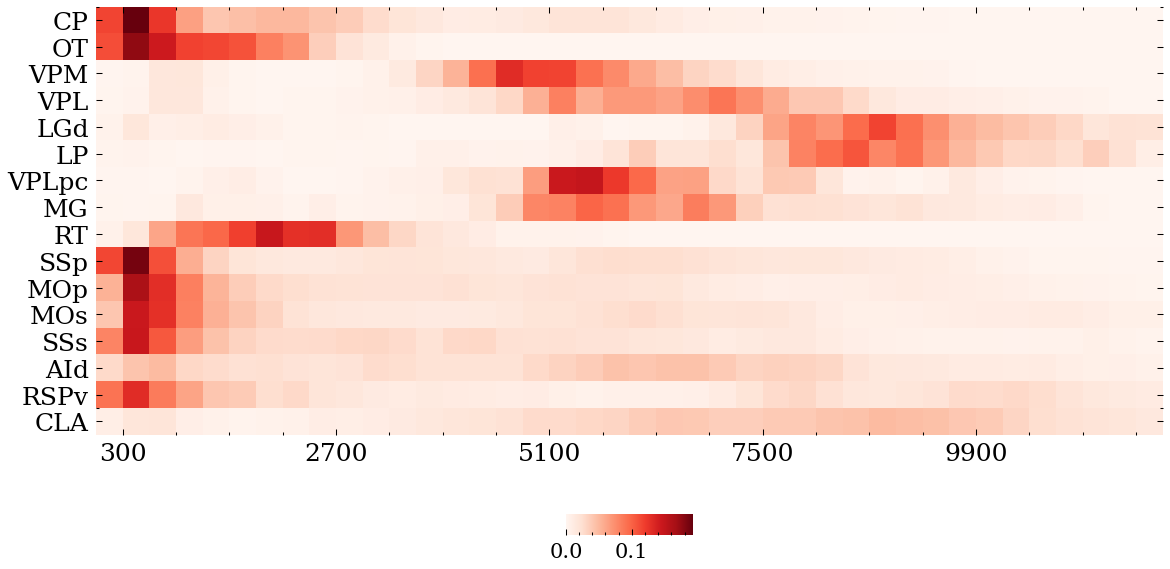

In [14]:
# bnum_stype_d2s=pd.read_csv('./bouton_dist2soma_stype.csv',index_col=['bin'])
d2s_bin_len=300
max_d2s_bins=40
fig=plt.figure(figsize=(8,4),dpi=150)
plt.subplot(111)
ax=sns.heatmap(bnum_stype_d2s,cmap='Reds',
               yticklabels=False,
            #    xticklabels=False,
            #    square=True, 
               cbar_kws={
                'orientation':'horizontal',
                'fraction':0.04,
                'aspect':6,
                })
plt.xticks(ticks=np.arange(1,max_d2s_bins,8),fontsize=12,labels=[str(c*d2s_bin_len) for c in np.arange(1,max_d2s_bins,8)],rotation=0)
# plt.xticks(fontsize=12)
# plt.xticks(ticks=np.arange(1,showbin,8),fontsize=10,labels=[str(c*d2s_bin_len) for c in np.arange(1,showbin,8)],rotation=0)
plt.yticks(ticks=np.arange(bnum_stype_d2s.shape[0])+0.5,labels=bnum_stype_d2s.index.to_list(),fontsize=12)
ax.yaxis.set_minor_locator(MaxNLocator(1))
# ax.xaxis.set_major_locator(MaxNLocator(5))
plt.ylabel('')
plt.tight_layout()
plt.show()
fig.savefig('./figs/bouton_distribution_dist2soma.png',dpi=300)

### bouton in 4 parts

In [15]:
'''path distance to soma: split into 4 parts'''
def bouton_dis_ratio(inswc,d2sfea='dist2soma',split_num=2):
    max_d2s=inswc[d2sfea].max()
    swc=inswc[inswc.type>=5].copy()
    dis_ratio=np.zeros(split_num)
    for b in np.arange(split_num):
        l=b*max_d2s/split_num
        r=(b+1)*max_d2s/split_num
        dratio=swc[(swc[d2sfea]>l)&(swc[d2sfea]<=r)].shape[0]/swc.shape[0]
        dis_ratio[b]=dratio
    return dis_ratio
bouton_ld_df_f='./bouton_local_distal_ratio.csv'
split_num=4
bouton_ld_df=pd.DataFrame(columns=['P'+str(p+1) for p in np.arange(split_num)])
if True:
    for root,dirs,files in os.walk(out_fea_path):
        for mfile in files:
            if mfile == '.DS_Store':
                continue
            file_in=os.path.join(root,mfile)
            fname=mfile.split('.eswc')[0]
            if fname in bouton_ld_df.index:
                continue
            swc=readswc(file=file_in,header=rheader,skiprows=1)
            if swc[swc.type>=5].shape[0]==0:
                continue
            bouton_ld_df.loc[fname,:]=bouton_dis_ratio(inswc=swc,split_num=split_num)

bouton_ld_df.index.name='name'
bouton_ld_df['soma_region']=morpho_feas['soma_region']
bouton_ld_df.loc[:,'brain_region']= 'Other'
bouton_ld_df.loc[bouton_ld_df['soma_region'].isin(CNU),'brain_region']= 'CNU'
bouton_ld_df.loc[bouton_ld_df['soma_region'].isin(CTX),'brain_region']= 'CTX'
bouton_ld_df.loc[bouton_ld_df['soma_region'].isin(TH),'brain_region']= 'TH'
bouton_ld_df.to_csv(bouton_ld_df_f)

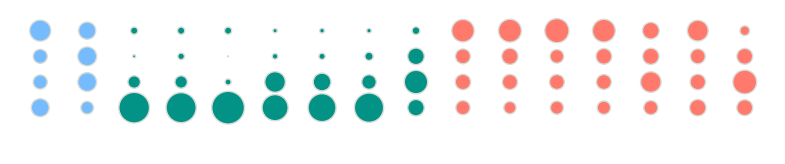

In [19]:
bouton_ld_df_f='./bouton_local_distal_ratio.csv'
bouton_ld_df=pd.read_csv(bouton_ld_df_f,index_col=['name'])
fig=plt.figure(figsize=(10,2),dpi=100)
ax=plt.subplot(111)
yd=split_num-np.arange(split_num)
m_max_size=600
for ai,astype in enumerate(ana_stypes):
    scolor=bcolors[2]
    if astype in cnu_stypes:
        scolor=bcolors[0]
    elif astype in th_stypes:
        scolor=bcolors[1]
    if astype == 'SSp':
        ana_data=bouton_ld_df[bouton_ld_df.soma_region.isin(ssp_regions)].copy()
    else:
        ana_data=bouton_ld_df[bouton_ld_df.soma_region==astype].copy()
    ana_data_mean=ana_data[['P'+str(p+1) for p in np.arange(split_num)]].mean().values
    ax.scatter(x=ai*np.ones(split_num),y=yd,s=ana_data_mean*m_max_size,c=scolor,alpha=1,marker='o',edgecolors='#d8dcd6')
ax.tick_params(axis='x',labelsize=14)
ax.tick_params(axis='y',labelsize=14)
# ax.xaxis.set_major_locator(MaxNLocator(5))
# ax.set_yticks(np.arange(split_num))
# ax.set_yticklabels([str((c+1)*0.25) for c in np.arange(split_num)])
plt.ylim([-1,5])
ax.set_axis_off()
# ax.set_xticks(np.arange(len(ana_stypes)))
# ax.set_xticklabels(ana_stypes)
# plt.ylim([-2,4])
# plt.grid(axis='y',linestyle=':',linewidth=1)
plt.show()
fig.savefig('./figs/bouton_local_distal_ratio.png',dpi=300)

## Fig2C 

### bouton distribution 最小生成树

In [33]:
from sklearn import metrics
def plot_bouton_mst_tree(inswc,direction='XY',
                         topath=None,title_text=None,
                         rid=None,linewidth=3,alpha=1,
                         soma_marker=100,bouton_marker=20,
                         bc='#fffe7a',lc='#ff796c',bec='#d8dcd6',
                         scale_bar=True,dpi=200,basic_width=3):
    # topo_bswc=nmt.swc.neuron(swc).swc
    direction_list=['XY','YZ','XZ','ALL']
    if direction.upper() not in direction_list:
        print('input is valid : direction=',direction)
        return None
    if rid is None:
        rid=get_rid(swc=inswc)
    soma=inswc.loc[rid,:]
    swc=inswc[(inswc.type>=5)|(inswc.type==1)].copy()
    df=swc[['x','y','z']].copy()
    X = sklearn.metrics.pairwise_distances(df)
    Tscr = minimum_spanning_tree(X).toarray()
    Tscr_df=pd.DataFrame(Tscr)
    Tscr_df[Tscr_df>0]=1
    df.reset_index(drop=False,inplace=True)
    if direction=='ALL':
        for d in np.arange(3):
            fig, ax = plt.subplots(1,1, figsize=(basic_width,basic_width),dpi=dpi)
            for n in Tscr_df.index:
                for c in Tscr_df.keys():
                    x1=[]
                    x2=[]
                    x3=[]
                    if Tscr_df.loc[n,c]==0:
                        continue
                    x1.append(df.loc[n,'x'])
                    x1.append(df.loc[c,'x'])
                    x2.append(df.loc[n,'y'])
                    x2.append(df.loc[c,'y'])
                    x3.append(df.loc[n,'z'])
                    x3.append(df.loc[c,'z'])
                    # print(x1,x2)
                    if direction_list[d].upper()=='YZ':
                        ax.plot(x2,x3,c=lc,linewidth=linewidth,alpha=alpha)
                        ax.scatter(x2, x3,s=bouton_marker,c=bc,label='bouton',edgecolors=bec,linewidths=0.2)
                        ax.scatter(soma['y'], soma['z'],s=soma_marker,c='black',label='soma')
                    elif direction_list[d].upper()=='XZ':
                        ax.plot(x1,x3,c=lc,linewidth=linewidth,alpha=alpha)
                        ax.scatter(x1, x3,s=bouton_marker,c=bc,label='bouton',edgecolors=bec,linewidths=0.2)
                        ax.scatter(soma['x'], soma['z'],s=soma_marker,c='black',label='soma')
                    else:
                        ax.plot(x1,x2,c=lc,linewidth=linewidth,alpha=alpha)
                        ax.scatter(x1, x2,s=bouton_marker,c=bc,label='bouton',edgecolors=bec,linewidths=0.2)
                        ax.scatter(soma['x'], soma['y'],s=soma_marker,c='black',label='soma')
            if scale_bar:
                x_len=100
                scale_len=math.floor(x_len*(ax.get_xlim()[1]-ax.get_xlim()[0])/(dpi*basic_width))*25
                xshift=(ax.get_xlim()[1]-ax.get_xlim()[0])/2
                sbar_startx=ax.get_xlim()[1]-xshift-(ax.get_xlim()[1]-ax.get_xlim()[0])/(dpi*basic_width/x_len)
                sbar_endx=ax.get_xlim()[1]-xshift
                sbar_y=ax.get_ylim()[0]+2
                ax.plot([sbar_startx,sbar_endx],[sbar_y,sbar_y],c='black',linewidth=2)
                ax.text(sbar_startx-5,sbar_y-20,str(round(scale_len,2))+'$\mu$m',fontsize=8)
            ax.set_axis_off()
            if title_text is not None:
                ax.set_title(title_text[d])
            if topath is not None:
                fig.savefig(topath[d],dpi=300)
    else:
        fig, ax = plt.subplots(1,1, figsize=(basic_width,basic_width),dpi=dpi)
        for n in Tscr_df.index:
            for c in Tscr_df.keys():
                x1=[]
                x2=[]
                x3=[]
                if Tscr_df.loc[n,c]==0:
                    continue
                x1.append(df.loc[n,'x'])
                x1.append(df.loc[c,'x'])
                x2.append(df.loc[n,'y'])
                x2.append(df.loc[c,'y'])
                x3.append(df.loc[n,'z'])
                x3.append(df.loc[c,'z'])
                # print(x1,x2)
                if direction.upper()=='YZ':
                    ax.plot(x2,x3,c=lc,linewidth=linewidth,alpha=alpha)
                    ax.scatter(x2, x3,s=bouton_marker,c=bc,label='bouton',edgecolors=bec,linewidths=0.1)
                    ax.scatter(soma['y'], soma['z'],s=soma_marker,c='black',label='soma')
                elif direction.upper()=='XZ':
                    ax.plot(x1,x3,c=lc,linewidth=linewidth,alpha=alpha)
                    ax.scatter(x1, x3,s=bouton_marker,c=bc,label='bouton',edgecolors=bec,linewidths=0.1)
                    ax.scatter(soma['x'], soma['z'],s=soma_marker,c='black',label='soma')
                else:
                    ax.plot(x1,x2,c=lc,linewidth=linewidth,alpha=alpha)
                    ax.scatter(x1, x2,s=bouton_marker,c=bc,label='bouton',edgecolors=bec,linewidths=0.1)
                    ax.scatter(soma['x'], soma['y'],s=soma_marker,c='black',label='soma')
        if scale_bar:
            x_len=100
            scale_len=math.floor(x_len*(ax.get_xlim()[1]-ax.get_xlim()[0])/(dpi*basic_width))*25
            xshift=(ax.get_xlim()[1]-ax.get_xlim()[0])/2
            sbar_startx=ax.get_xlim()[1]-xshift-(ax.get_xlim()[1]-ax.get_xlim()[0])/(dpi*basic_width/x_len)
            sbar_endx=ax.get_xlim()[1]-xshift
            sbar_y=ax.get_ylim()[1]-1
            ax.plot([sbar_startx,sbar_endx],[sbar_y,sbar_y],c='black',linewidth=2)
            ax.text(sbar_startx-2,sbar_y+6,str(round(scale_len,2))+'$\mu$m',fontsize=16)
        ax.set_axis_off()
        if title_text is not None:
            ax.set_title(title_text)
        if topath is not None:
            fig.savefig(topath,dpi=300)            
    return Tscr_df
showdata=allfeas_df_s.copy()
showdata['soma_region']=[morpho_feas.loc[n,'soma_region'] for n in showdata.index]
showdata=showdata[showdata.soma_region.isin(ana_regions)].copy()
# brbfeas.loc[:,'brain_region']= 'Other'
showdata.loc[showdata['soma_region'].isin(CNU),'brain_region']= 'CNU'
showdata.loc[showdata['soma_region'].isin(CTX),'brain_region']= 'CTX'
showdata.loc[showdata['soma_region'].isin(TH),'brain_region']= 'TH'

In [31]:
def get_mean_neuron(indata,mean_feas,type='VPM'):
    indf=indata[indata.brain_region==type].copy()
    cmpfeas=mean_feas.keys().to_list()
    indf['dist2mean']=[(abs(mean_feas-indf.loc[cell,cmpfeas])).sum() for cell in indf.index]
    indf.sort_values(by='dist2mean',inplace=True)
    return indf['dist2mean']
gpdata=showdata.groupby(['brain_region'])
for bt in btype:
    print("Now in region: "+bt)
    thisgp=gpdata.get_group(bt).copy()
    thisgp.drop(['soma_region','brain_region'],axis=1,inplace=True)
    outdf=get_mean_neuron(indata=showdata,mean_feas=thisgp.mean(),type=bt)
    print(outdf.head(5).index)
# outdf

Now in region: CNU
Index(['18464_00081', '18867_4724_x12558_y16835', '18464_00016', '18457_00001',
       '18457_00038'],
      dtype='object', name='name')
Now in region: TH
Index(['18454_01049', '18454_01063', '18454_00140', '18455_00143',
       '18454_01047'],
      dtype='object', name='name')
Now in region: CTX
Index(['18864_00026', 'pre_18864_00153', 'pre_18864_00043',
       '17300_5896_x24862_y27320', '18869_4302_x23433_y9053'],
      dtype='object', name='name')


In [ ]:
### CNU bouton MST
show_cell='18457_00001.eswc'
tf=os.path.join(out_fea_path,show_cell)
swc=readswc(file=tf,header=rheader,skiprows=1)
mst=plot_bouton_mst_tree(swc,direction='ALL',
                     bouton_marker=15,linewidth=1,
                     bec='black',lc='#ff796c',
                     topath=['./figs/'+d+show_cell+'_mst.png' for d in ['XY','YZ','XZ']])

In [ ]:
###  TH bouton MST
show_cell='18455_00143.eswc'
tf=os.path.join(out_fea_path,show_cell)
swc=readswc(file=tf,header=rheader,skiprows=1)
mst=plot_bouton_mst_tree(swc,direction='ALL',
                     bouton_marker=15,linewidth=1,
                     bec='black',lc='#ff796c',
                     topath=['./figs/'+d+show_cell+'_mst.png' for d in ['XY','YZ','XZ']])

In [ ]:
### CTX bouton MST
show_cell='pre_18864_00153.eswc'
tf=os.path.join(out_fea_path,show_cell)
swc=readswc(file=tf,header=rheader,skiprows=1)
mst=plot_bouton_mst_tree(swc,direction='ALL',
                     bouton_marker=15,linewidth=1,
                     bec='black',lc='#ff796c',
                     topath=['./figs/'+d+show_cell+'_mst.png' for d in ['XY','YZ','XZ']])

### S-types不同feature之间的对比：雷达图

464.05882352941177

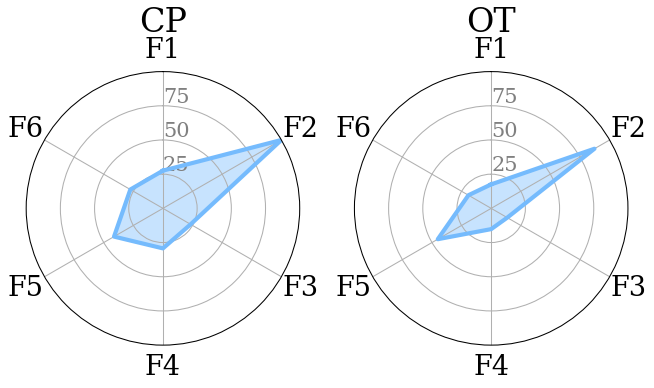

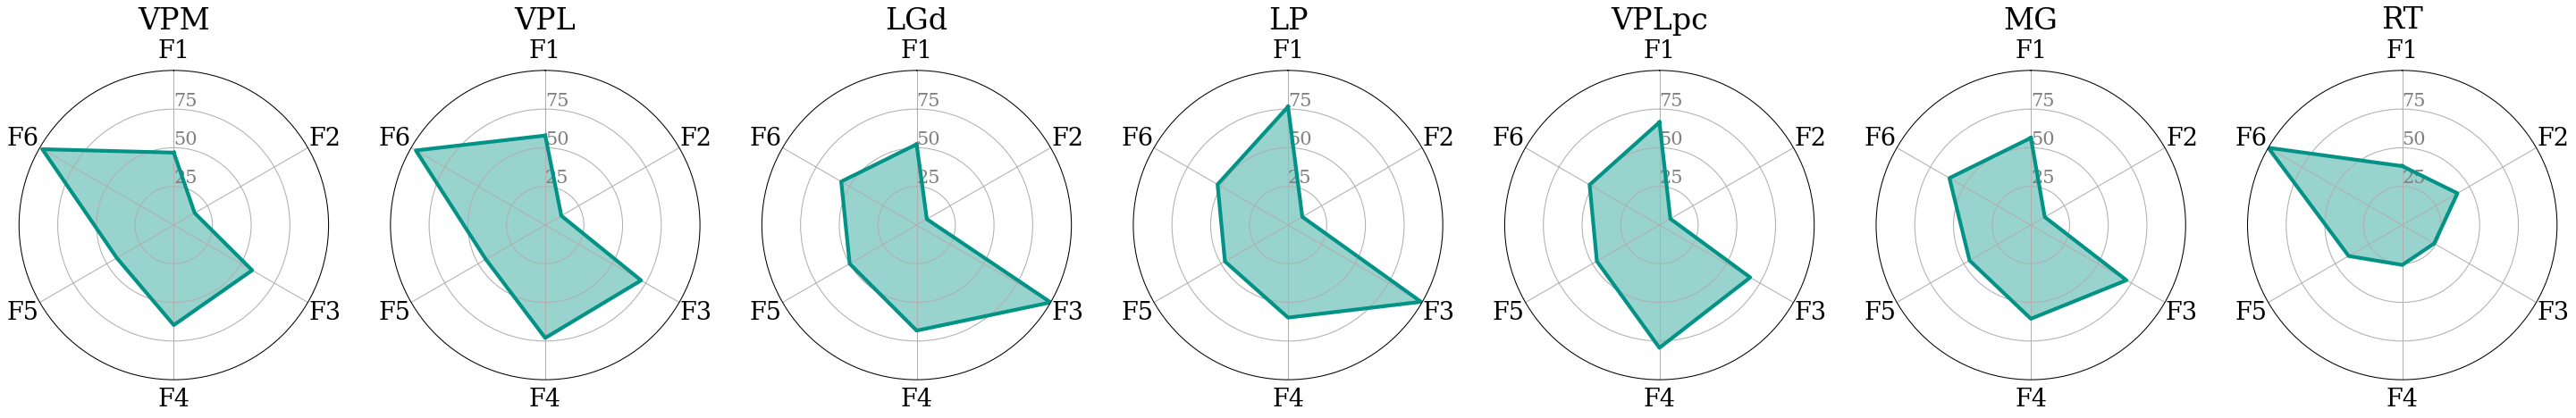

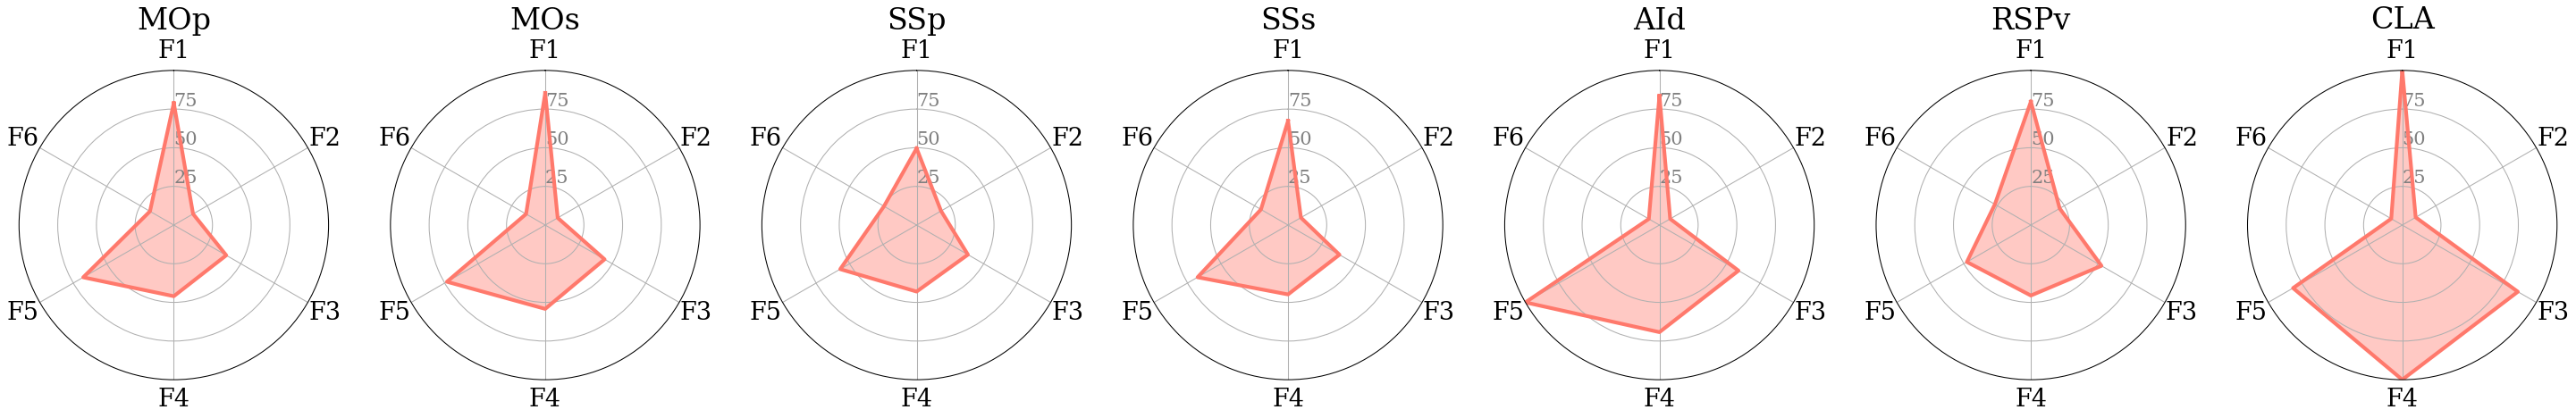

In [82]:
'''features: `radar_feas`'''
# raw_feas_file='ana_bouton_features.csv'
# all_feas=pd.read_csv(raw_feas_file,index_col=['name'])

# cell_simple_col=['name','projection_type','bnum','teb','br','bpath_den','bgeo_dist','targets']
radar_feas_labels=['# boutons','tebratio','d2s_mean','ed2s_mean','binterval_mean','neighborb_mean']
radar_feas=['F'+str(x+1) for x in np.arange(len(radar_feas_labels))]
radar_fea_array_all=np.zeros((len(ana_stypes),len(radar_feas)),)
for ity,ty in enumerate(ana_stypes):
    if ty == 'SSp':
        ty_df=all_feas[all_feas.soma_region.isin(ssp_regions)].copy()
    else:
        ty_df=all_feas[all_feas.soma_region==ty].copy()
    radar_fea_array_all[ity,0]=ty_df['bnum'].mean(0)
    radar_fea_array_all[ity,1]=ty_df['tebratio'].mean(0)
    radar_fea_array_all[ity,2]=ty_df['pd2s_mean'].mean(0)
    radar_fea_array_all[ity,3]=ty_df['ed2s_mean'].mean(0)
    radar_fea_array_all[ity,4]=ty_df['binterval_mean'].mean(0)
    radar_fea_array_all[ity,5]=ty_df['neighborb_mean'].mean(0)
def make_spider(df,row, title,color,type_num=6):
    # number of variable
    categories=list(df)[:-1]
    # print(categories)
    N = len(categories)

    # What will be the angle of each axis in the plot? (we divide the plot / number of variable)
    angles = [n / float(N) * 2 * pi for n in range(N)]
    angles += angles[:1]

    # Initialise the spider plot
    ax = plt.subplot(1,type_num+1,row+1, polar=True, )

    # If you want the first axis to be on top:
    ax.set_theta_offset(pi / 2)
    ax.set_theta_direction(-1)

    # Draw one axe per variable + add labels labels yet
    plt.xticks(angles[:-1], categories, color='black', size=13)
    # ax.set_xticklabels(rotation=45)

    # Draw ylabels
    ax.set_rlabel_position(0)
    plt.yticks([25,50,75], ["25","50","75"], color="grey", size=10)
    plt.ylim(0,100)

    # Ind1
    values=df.loc[row].drop('S-type').values.flatten().tolist()
    values += values[:1]
    ax.plot(angles, values, color=color, linewidth=2, linestyle='solid')
    ax.fill(angles, values, color=color, alpha=0.4)
    # Add a title
    plt.title(title, size=16, color='black', y=1.1)
for ti,ana_types in enumerate([cnu_stypes,th_stypes,ctx_stypes]):
    # ana_types=ctx_stypes
    radar_fea_array=np.zeros((len(ana_types),len(radar_feas)),)
    for ity,ty in enumerate(ana_types):
        if ty == 'SSp':
            ty_df=all_feas[all_feas.soma_region.isin(ssp_regions)].copy()
        else:
            ty_df=all_feas[all_feas.soma_region==ty].copy()
        radar_fea_array[ity,0]=ty_df['bnum'].mean(0)
        radar_fea_array[ity,1]=ty_df['tebratio'].mean(0)
        radar_fea_array[ity,2]=ty_df['pd2s_mean'].mean(0)
        radar_fea_array[ity,3]=ty_df['ed2s_mean'].mean(0)
        radar_fea_array[ity,4]=ty_df['binterval_mean'].mean(0)
        radar_fea_array[ity,5]=ty_df['neighborb_mean'].mean(0)
    #normalized to 0-100
    for i in range(len(radar_feas)):
        radar_fea_array[:,i]/=np.max(radar_fea_array_all[:,i])
    #
    radar_fea_df=pd.DataFrame(100*radar_fea_array,columns=radar_feas)
    radar_fea_df['S-type']=ana_types

    my_dpi=150
    rader_fig=plt.figure(figsize=(4*len(ana_types),4), dpi=my_dpi)
    
    # Loop to plot
    for row in range(0, len(radar_fea_df.index)):
        make_spider(radar_fea_df,row=row, title=radar_fea_df['S-type'][row],color=bcolors[ti],type_num=len(ana_types))
    rader_fig.savefig('./figs/'+str(btype[ti])+'_features.png',dpi=my_dpi)

In [85]:
### get feature range
for i in np.arange(len(radar_feas)):
    print(radar_feas_labels[i],np.min(radar_fea_array_all[:,i]),np.max(radar_fea_array_all[:,i]))

# boutons 464.05882352941177 2645.2758620689656
tebratio 0.0012104126949790475 0.015862083054592066
d2s_mean 1195.8381195619256 8818.13573676374
ed2s_mean 641.4305580097853 4226.145693391694
binterval_mean 11.153329216978733 27.869768711307255
neighborb_mean 11.999598119490225 151.53232693304545


/var/folders/pn/1ylwqzwn1fqclh7y29504d7h0000gn/T/ipykernel_9768/3199682308.py:26: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.



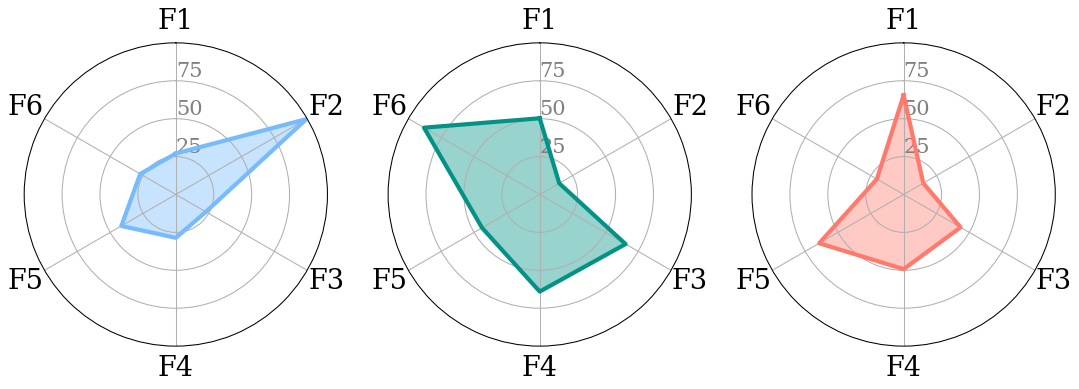

In [21]:
ana_types=[cnu_stypes,th_stypes,ctx_stypes]
radar_fea_array=np.zeros((len(ana_types),len(radar_feas)),)
for ity,ty in enumerate(ana_types):
    if ty.count('SSp'):
        ty_df=all_feas[(all_feas.soma_region.isin(ssp_regions))|
                       (all_feas.soma_region.isin(ty))].copy()
    else:
        ty_df=all_feas[all_feas.soma_region.isin(ty)].copy()
    radar_fea_array[ity,0]=ty_df['bnum'].mean(0)
    radar_fea_array[ity,1]=ty_df['tebratio'].mean(0)
    radar_fea_array[ity,2]=ty_df['pd2s_mean'].mean(0)
    radar_fea_array[ity,3]=ty_df['ed2s_mean'].mean(0)
    radar_fea_array[ity,4]=ty_df['binterval_mean'].mean(0)
    radar_fea_array[ity,5]=ty_df['neighborb_mean'].mean(0)
#normalized to 0-100
for i in range(len(radar_feas)):
    radar_fea_array[:,i]/=(np.max(radar_fea_array_all[:,i]))
#

radar_fea_df=pd.DataFrame(100*radar_fea_array,columns=radar_feas)
radar_fea_df['B-type']=btype
my_dpi=150
rader_fig=plt.figure(figsize=(4*len(ana_types),4), dpi=my_dpi)
 
# Create a color palette:
my_palette = plt.cm.get_cmap("Set2", len(radar_fea_df.index))
def make_spider(df,row, title,color,type_num=6):
    # number of variable
    categories=list(df)[:-1]
    # print(categories)
    N = len(categories)

    # What will be the angle of each axis in the plot? (we divide the plot / number of variable)
    angles = [n / float(N) * 2 * pi for n in range(N)]
    angles += angles[:1]

    # Initialise the spider plot
    ax = plt.subplot(1,type_num+1,row+1, polar=True, )

    # If you want the first axis to be on top:
    ax.set_theta_offset(pi / 2)
    ax.set_theta_direction(-1)

    # Draw one axe per variable + add labels labels yet
    plt.xticks(angles[:-1], categories, color='black', size=13)
    # ax.set_xticklabels(rotation=45)

    # Draw ylabels
    ax.set_rlabel_position(0)
    plt.yticks([25,50,75], ["25","50","75"], color="grey", size=10)
    plt.ylim(0,100)

    # Ind1
    values=df.loc[row].drop('B-type').values.flatten().tolist()
    values += values[:1]
    ax.plot(angles, values, color=color, linewidth=2, linestyle='solid')
    ax.fill(angles, values, color=color, alpha=0.4)
    # Add a title
    # plt.title(title, size=16, color='black', y=1.1)
# Loop to plot
for row in range(0, len(radar_fea_df.index)):
    make_spider(radar_fea_df,row=row, title=radar_fea_df['B-type'][row],color=bcolors[row],type_num=len(ana_types))

rader_fig.savefig('./figs/btype_cmp_features.png',dpi=my_dpi)

## Fig7D

In [40]:
def read_br_boutons(file_in):
    brfea_raw=pd.read_csv(file_in)
    axonal_brfea=brfea_raw[brfea_raw.type==2].copy()
    
    withb_brfea=axonal_brfea[axonal_brfea.bnum>0].copy()
    withbbr=axonal_brfea[axonal_brfea.bnum>0].shape[0]
    axonal_tip_brs=axonal_brfea[(axonal_brfea.lstips+axonal_brfea.rstips==0)].shape[0]
    axonal_tip_wb_brs=axonal_brfea[(axonal_brfea.bnum>0)&(axonal_brfea.lstips+axonal_brfea.rstips==0)].shape[0]
    nobbr=axonal_brfea[axonal_brfea.bnum==0].shape[0]
    axonal_bif_brs=axonal_brfea[(axonal_brfea.lstips+axonal_brfea.rstips>0)].shape[0]
    axonal_bif_wb_brs=axonal_brfea[(axonal_brfea.bnum>0)&(axonal_brfea.lstips+axonal_brfea.rstips>0)].shape[0]
    
    bnums=withb_brfea['bnum'].mean()
    w_br_tor=1-withb_brfea.loc[withb_brfea.pathlength>50,'contraction'].mean()
    n_br_tor=1-axonal_brfea.loc[(axonal_brfea.bnum==0)&(axonal_brfea.pathlength>50),'contraction'].mean()
    withb_br_len=withb_brfea['pathlength'].mean()
    nob_br_len=axonal_brfea.loc[axonal_brfea.bnum==0,'pathlength'].mean()
    # withb_br_angle=withb_brfea['angle'].mean()
    withbbif=axonal_brfea[(axonal_brfea.bnum>0)&(axonal_brfea.lstips>0)].shape[0]
    nobbif=axonal_brfea[(axonal_brfea.bnum==0)&(axonal_brfea.lstips>0)].shape[0]
    withb_br_angle=axonal_brfea.loc[(axonal_brfea.bnum>0)&(axonal_brfea.lstips>0),'angle'].mean()
    nob_br_angle=axonal_brfea.loc[(axonal_brfea.bnum==0)&(axonal_brfea.lstips>0),'angle'].mean()
    withb_br_rangle=axonal_brfea.loc[(axonal_brfea.bnum>0)&(axonal_brfea.lstips>0),'angle_remote'].mean()
    nob_br_rangle=axonal_brfea.loc[(axonal_brfea.bnum==0)&(axonal_brfea.lstips>0),'angle_remote'].mean()
    # withb_br_rangle=withb_brfea['angle_remote'].mean()
    # nob_br_rangle=axonal_brfea.loc[axonal_brfea.bnum==0,'angle_remote'].mean()
    return [withbbr,nobbr,axonal_tip_brs,axonal_tip_wb_brs,axonal_bif_brs,axonal_bif_wb_brs,bnums,withb_br_len,nob_br_len,w_br_tor,n_br_tor,
            withbbif,nobbif,withb_br_angle,nob_br_angle,withb_br_rangle,nob_br_rangle]
brfea_dir='./brfeas'
brbrfeas_col_labels=['withbbr','nobbr','axonal_tip_brs','axonal_tip_wb_brs','axonal_bif_brs','axonal_bif_wb_brs','bnums','withb_br_len','nob_br_len','w_br_tor','n_br_tor',
            'withbbif','nobbif','withb_br_angle','nob_br_angle','withb_br_rangle','nob_br_rangle']
brbfeas=pd.DataFrame(columns=brbrfeas_col_labels)
for root,dirs,files in os.walk(brfea_dir):
    for mfile in files:
        # print(mfile)
        if os.path.splitext(mfile)[1] != '.csv':
            continue
        file_in=os.path.join(root,mfile)
        brbfea=read_br_boutons(file_in=file_in)
        fname=mfile.split('.eswc')[0]
        if fname in brbfeas.index:
            continue
        brbfeas.loc[fname,:]=brbfea
brbfeas.index.name='name'
brbfeas['soma_region']=morpho_feas['soma_region']
brbfeas.loc[:,'brain_region']= 'Other'
brbfeas.loc[brbfeas['soma_region'].isin(CNU),'brain_region']= 'CNU'
brbfeas.loc[brbfeas['soma_region'].isin(CTX),'brain_region']= 'CTX'
brbfeas.loc[brbfeas['soma_region'].isin(TH),'brain_region']= 'TH'
brbfeas.to_csv('./ana_branch_bouton_features.csv',float_format='%.3f')

In [90]:
brbfeas=pd.read_csv('./ana_branch_bouton_features.csv',index_col=['name'])

In [91]:
brbfeas

,withbbr,nobbr,axonal_tip_brs,axonal_tip_wb_brs,axonal_bif_brs,axonal_bif_wb_brs,bnums,withb_br_len,nob_br_len,w_br_tor,n_br_tor,withbbif,nobbif,withb_br_angle,nob_br_angle,withb_br_rangle,nob_br_rangle,soma_region,brain_region
name,,,,,,,,,,,,,,,,,,,
17545_00173,193,49,116,102,126,91,7.844560,127.751426,182.921702,0.173955,0.171845,91,35,57.567481,63.905861,59.795266,71.621434,LGd,TH
17545_00172,180,37,85,78,132,102,4.427778,77.048630,205.094789,0.186675,0.195407,102,30,64.141766,57.869881,64.247630,55.344767,VPM,TH
18454_00166,183,86,111,99,158,84,4.087432,94.346238,124.433642,0.104317,0.128208,84,74,89.174367,81.893166,78.734545,76.847814,VPL,TH
pre_17543_01276,62,20,41,29,41,33,5.161290,317.036631,332.713067,0.181179,0.183777,33,8,69.681685,84.018745,70.884021,77.672362,error,Other
18864_3494_x2380_y13749,281,72,176,140,177,141,6.003559,251.281517,214.998452,0.198671,0.122075,141,36,69.196133,66.268796,74.586120,72.574853,MOp,CTX
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18465_00230,92,42,62,47,72,45,5.652174,103.176400,172.323233,0.133080,0.137273,45,27,66.977967,85.110178,55.813270,63.043572,VPM,TH
17302_00041,164,52,98,82,118,82,7.164634,139.486042,185.558751,0.147362,0.185699,82,36,65.457267,67.017865,60.322605,66.267744,LGd,TH
18867_4156_x9348_y9148,176,52,112,96,116,80,4.579545,93.907601,263.192544,0.197254,0.163002,80,36,78.555698,78.163134,76.265469,79.966953,SSp-m,CTX


In [43]:
brbfeas=pd.read_csv('./ana_branch_bouton_features.csv',index_col=['name'])
sdata=brbfeas[brbfeas.soma_region.isin(ana_regions)].copy()
brbfeas_stat=sdata[sdata.brain_region.isin(btype)].copy()
brbfeas_stat=brbfeas_stat[['withbbr', 'nobbr','withb_br_len', 'nob_br_len', 'w_br_tor',
       'n_br_tor','withb_br_angle','nob_br_angle','withb_br_rangle','nob_br_rangle','brain_region']].groupby(['brain_region']).mean()
brbfeas_stat

,withbbr,nobbr,withb_br_len,nob_br_len,w_br_tor,n_br_tor,withb_br_angle,nob_br_angle,withb_br_rangle,nob_br_rangle
brain_region,,,,,,,,,,
CNU,151.281525,47.841642,85.259786,103.117811,0.228470,0.191546,82.462736,84.892298,82.700667,84.681285
CTX,271.149905,82.719165,209.853086,212.845149,0.181873,0.157624,73.542447,78.072814,71.519904,74.887432
TH,233.779789,76.708899,98.867658,135.209979,0.144173,0.160364,75.632274,77.760486,69.367425,72.239304


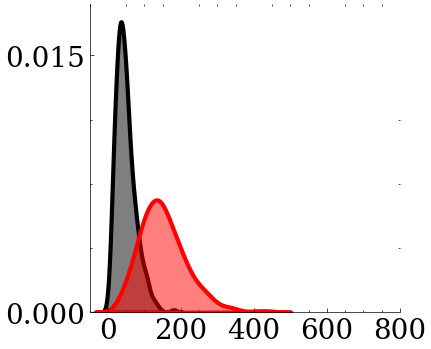

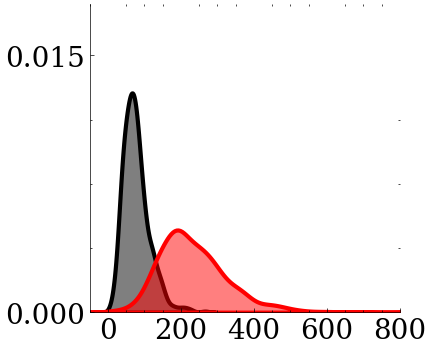

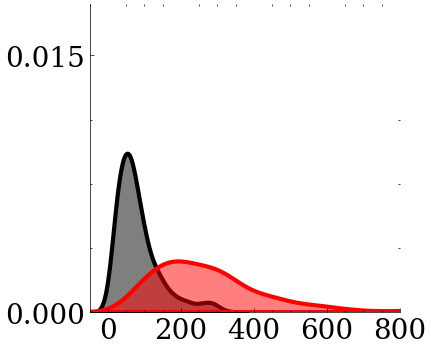

In [49]:
'''with bouton br_size VS null bouton br_size'''
# sdata=brbfeas.copy()
for bt in btype:
    fig=plt.figure(figsize=(4,4),dpi=100)
    fs=16
    plt.subplot(111)
    ax=sns.kdeplot(data=sdata[sdata.brain_region==bt],
                x='nobbr',fill=True,linewidth=3,
                color='black',alpha=0.5
                #    hue='brain_region',hue_order=btype,
                #    palette=bpla,common_norm=False
                )
    ax=sns.kdeplot(data=sdata[sdata.brain_region==bt],
                x='withbbr',fill=True,linewidth=3,
                color='red',alpha=0.5
                #    hue='brain_region',hue_order=btype,
                #    palette=bpla,common_norm=False
                )
    ax.tick_params(axis='x',labelsize=20)
    ax.xaxis.set_major_locator(MaxNLocator(5))
    ax.tick_params(axis='y',labelsize=20)
    ax.yaxis.set_major_locator(MaxNLocator(1))
    ax.tick_params(top=False,right=False)
    # ax.yaxis.set_minor_locator(MaxNLocator(1))
    # ax.set_axis_off()
    # plt.legend(['CTX','TH','CNU'],title='',fontsize=fs,loc='upper right')
    plt.xlabel('',fontsize=fs+2)
    plt.ylabel('',fontsize=fs+2)
    plt.xlim([-50,800])
    # plt.xlim([-0.1,0.4])
    plt.ylim([0,0.018])
    # plt.title(bt,fontsize=20,y=0.85)
    plt.gca().spines["top"].set_alpha(.0)
    # plt.gca().spines["bottom"].set_alpha(.0)
    plt.gca().spines["right"].set_alpha(.0)
    # plt.gca().spines["left"].set_alpha(.0)
    plt.show()
    fig.savefig('./figs/branches_num_cmp_'+bt+'.png',dpi=300)

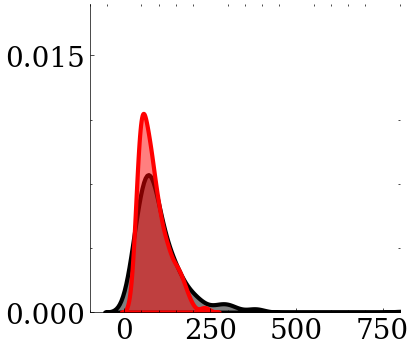

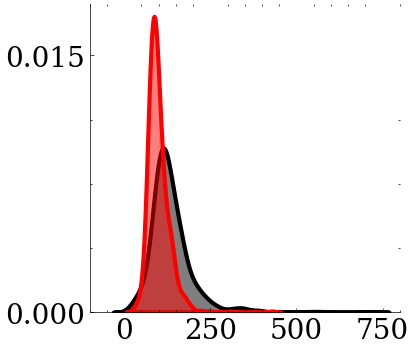

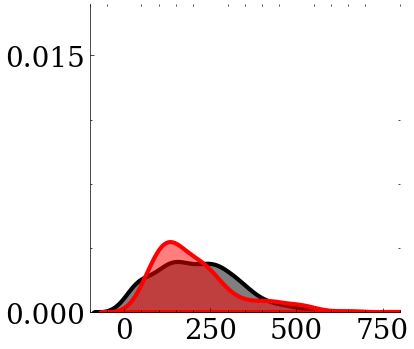

In [50]:
'''with bouton br_size VS null bouton br_size'''
# sdata=brbfeas.copy()
for bt in btype:
    fig=plt.figure(figsize=(4,4),dpi=100)
    fs=16
    plt.subplot(111)
    ax=sns.kdeplot(data=sdata[sdata.brain_region==bt],
                x='nob_br_len',fill=True,linewidth=3,
                color='black',alpha=0.5
                #    hue='brain_region',hue_order=btype,
                #    palette=bpla,common_norm=False
                )
    ax=sns.kdeplot(data=sdata[sdata.brain_region==bt],
                x='withb_br_len',fill=True,linewidth=3,
                color='red',alpha=0.5
                #    hue='brain_region',hue_order=btype,
                #    palette=bpla,common_norm=False
                )
    ax.tick_params(axis='x',labelsize=20)
    ax.xaxis.set_major_locator(MaxNLocator(4))
    ax.tick_params(axis='y',labelsize=20)
    ax.yaxis.set_major_locator(MaxNLocator(1))
    ax.tick_params(top=False,right=False)
    # ax.yaxis.set_minor_locator(MaxNLocator(1))
    # ax.set_axis_off()
    # plt.legend(['CTX','TH','CNU'],title='',fontsize=fs,loc='upper right')
    plt.xlabel('',fontsize=fs+2)
    plt.ylabel('',fontsize=fs+2)
    plt.xlim([-100,800])
    # plt.xlim([-0.1,0.4])
    plt.ylim([0,0.018])
    # plt.title(bt,fontsize=20,y=0.85)
    plt.gca().spines["top"].set_alpha(.0)
    # plt.gca().spines["bottom"].set_alpha(.0)
    plt.gca().spines["right"].set_alpha(.0)
    # plt.gca().spines["left"].set_alpha(.0)
    plt.show()
    fig.savefig('./figs/branches_len_cmp_'+bt+'.png',dpi=300)

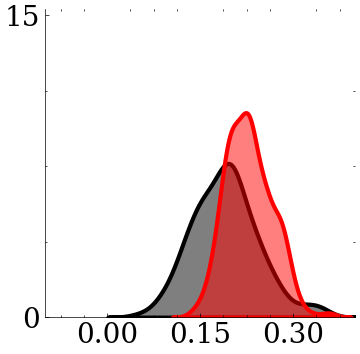

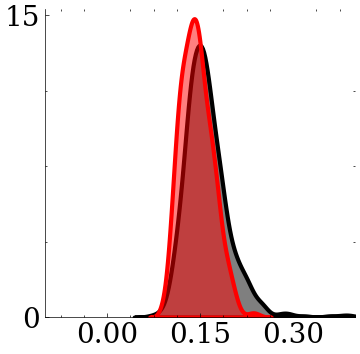

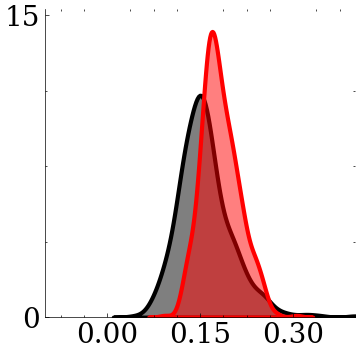

In [51]:
'''with bouton br_size VS null bouton br_size'''
# sdata=brbfeas.copy()
for bt in btype:
    fig=plt.figure(figsize=(4,4),dpi=100)
    fs=16
    plt.subplot(111)
    ax=sns.kdeplot(data=sdata[sdata.brain_region==bt],
                x='n_br_tor',fill=True,linewidth=3,
                color='black',alpha=0.5
                #    hue='brain_region',hue_order=btype,
                #    palette=bpla,common_norm=False
                )
    ax=sns.kdeplot(data=sdata[sdata.brain_region==bt],
                x='w_br_tor',fill=True,linewidth=3,
                color='red',alpha=0.5
                #    hue='brain_region',hue_order=btype,
                #    palette=bpla,common_norm=False
                )
    ax.tick_params(axis='x',labelsize=20)
    ax.xaxis.set_major_locator(MaxNLocator(4))
    ax.tick_params(axis='y',labelsize=20)
    ax.yaxis.set_major_locator(MaxNLocator(1))
    ax.tick_params(top=False,right=False)
    # ax.yaxis.set_minor_locator(MaxNLocator(1))
    # ax.set_axis_off()
    # plt.legend(['CTX','TH','CNU'],title='',fontsize=fs,loc='upper right')
    plt.xlabel('',fontsize=fs+2)
    plt.ylabel('',fontsize=fs+2)
    # plt.xlim([-100,800])
    plt.xlim([-0.1,0.4])
    plt.ylim([0,15.3])
    # plt.title(bt,fontsize=20,y=0.85)
    plt.gca().spines["top"].set_alpha(.0)
    # plt.gca().spines["bottom"].set_alpha(.0)
    plt.gca().spines["right"].set_alpha(.0)
    # plt.gca().spines["left"].set_alpha(.0)
    plt.show()
    fig.savefig('./figs/branches_tor_cmp_'+bt+'.png',dpi=300)

## Fig7E

In [52]:
def read_br_boutons_v0(file_in):
    brfea_raw=pd.read_csv(file_in,index_col=['id'])
    pbnum_ratios=[]
    for br in brfea_raw.index:
        if brfea_raw.loc[br,'bnum'] and brfea_raw.loc[br,'pbnum']:
            pbnum=brfea_raw.loc[br,'pbnum']
            pbnum_ratios.append(pbnum/brfea_raw.loc[br,'bnum'])
    if len(pbnum_ratios):
        avg_pbnum_ratios=np.mean(pbnum_ratios)
    else:
        return None
    # get tip-brs
    tips=[]
    for br in brfea_raw.index:
        if br in brfea_raw['parent_id'].to_list():
            continue
        tips.append(br)
    # for none tip-br
    wbbrs=0
    no_child_br_wb=0
    one_child_br_wb=0
    two_child_br_wb=0
    for br in brfea_raw.index:
        if br in tips:
            continue
        if brfea_raw.loc[br,'bnum']:
            wbbrs+=1
            wb_childbr=0
            if brfea_raw.loc[br,'lcbnum']:
                wb_childbr+=1
            if brfea_raw.loc[br,'rcbnum']:
                wb_childbr+=1
            if wb_childbr ==1:
                one_child_br_wb+=1
            elif wb_childbr ==2:
                two_child_br_wb+=1
            else:
                no_child_br_wb+=1
    if wbbrs:
        no_child_br_wb_ratio=no_child_br_wb/wbbrs
        one_child_br_wb_ratio=one_child_br_wb/wbbrs
        two_child_br_wb_ratio=two_child_br_wb/wbbrs
        return [avg_pbnum_ratios,no_child_br_wb_ratio,one_child_br_wb_ratio,two_child_br_wb_ratio]
    else:
        return None
brfea_dir='./brfeas'
brbrfeas_col_labels=['avg_pbnum_ratios','no_child_br_wb_ratio','one_child_br_wb_ratio','two_child_br_wb_ratio']
brbfeas=pd.DataFrame(columns=brbrfeas_col_labels)
for root,dirs,files in os.walk(brfea_dir):
    for mfile in files:
        # print(mfile)
        if os.path.splitext(mfile)[1] != '.csv':
            continue
        file_in=os.path.join(root,mfile)
        brbfea=read_br_boutons_v0(file_in=file_in)
        if brbfea is None:
            continue
        fname=mfile.split('.eswc')[0]
        if fname in brbfeas.index:
            continue
        brbfeas.loc[fname,:]=brbfea
brbfeas.index.name='name'
brbfeas['soma_region']=morpho_feas['soma_region']
brbfeas.loc[:,'brain_region']= 'Other'
brbfeas.loc[brbfeas['soma_region'].isin(CNU),'brain_region']= 'CNU'
brbfeas.loc[brbfeas['soma_region'].isin(CTX),'brain_region']= 'CTX'
brbfeas.loc[brbfeas['soma_region'].isin(TH),'brain_region']= 'TH'
brbfeas.to_csv('./branch_bouton_parent_child2.csv',float_format='%.3f')

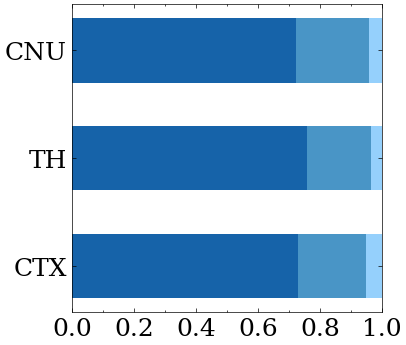

In [60]:
fig, ax = plt.subplots(1,1, figsize=(4,4),dpi=100)
w=0.6
fs=18
sdata=brbfeas[brbfeas.soma_region.isin(ana_regions)].copy()
showdata=sdata[['two_child_br_wb_ratio','one_child_br_wb_ratio','no_child_br_wb_ratio','brain_region']].groupby('brain_region').mean()
b=np.zeros(3)
scolors=['#1663A9','#4995c6','#95d0fc','#d0fefe']
for i,key in enumerate(['two_child_br_wb_ratio','one_child_br_wb_ratio','no_child_br_wb_ratio']):
    ratios=[showdata.loc[bt,key] for bt in btype]
    # ax.bar(btype,ratios,width=w,bottom=b,color=scolors[i],fill=True)
    ax.barh(btype,ratios,height=w,left=b,color=scolors[i],fill=True)
    b+=ratios
plt.xlim([0,1])
ax.tick_params(axis='x',labelsize=fs)
ax.tick_params(axis='y',labelsize=fs)
ax.xaxis.set_major_locator(MaxNLocator(5))
ax.xaxis.set_minor_locator(MaxNLocator(10))
ax.yaxis.set_minor_locator(MaxNLocator(1))
ax.invert_yaxis()
plt.show()
fig.savefig('./figs/bouton_distribution_in_topo_related_branch.png',dpi=300)

## Fig7F bouton distribution in branch
1. split bouton branch into 4 parts
2. normalized bouton density barcode

In [67]:
sdata_dir='./bouton_in_branch/S4'
split_num=4
topath_f='./all_bouton_branch_data_split_'+str(split_num)+'.csv'
split_feas=['S'+str(x+1) for x in np.arange(split_num)]
all_ana_data=pd.DataFrame()
if True:
    for root,dirs,files in os.walk(sdata_dir):
        for mfile in files:
            if mfile == '.DS_Store':
                continue
            file_in=os.path.join(root,mfile)
            fname=mfile.split('.eswc')[0]
            indata=pd.read_csv(file_in)
            indata=indata[indata.total>=split_num].copy()
            for fea in split_feas:
                indata[fea]/=indata['total']
            indata['fname']=fname
            indata['stype']=morpho_feas.loc[fname,'soma_region']
            all_ana_data=pd.concat([all_ana_data,indata],axis=0,ignore_index=True)

all_ana_data.index.name='brindex'
all_ana_data.to_csv(topath_f)

In [68]:
all_ana_data

,S1,S2,S3,S4,tip_br,total,order,dist2soma,contraction,length,fname,stype
brindex,,,,,,,,,,,,
0,0.250000,0.375000,0.375000,0.000000,0,8,7,7246.29,0.873760,116.8490,17545_00173,LGd
1,0.000000,0.000000,0.000000,1.000000,1,8,9,7366.06,0.771664,813.6470,17545_00173,LGd
2,0.400000,0.200000,0.000000,0.400000,0,10,9,7600.20,0.832315,175.7790,17545_00173,LGd
3,0.500000,0.500000,0.000000,0.000000,0,4,10,7366.49,0.871767,103.2740,17545_00173,LGd
4,0.166667,0.333333,0.500000,0.000000,0,6,10,7715.05,0.869694,132.4780,17545_00173,LGd
...,...,...,...,...,...,...,...,...,...,...,...,...
229994,0.000000,0.700000,0.300000,0.000000,1,10,48,11288.00,0.792489,354.1890,18458_00150,LP
229995,0.333333,0.222222,0.333333,0.111111,1,9,49,10024.50,0.863754,201.6190,18458_00150,LP
229996,0.500000,0.250000,0.250000,0.000000,0,4,49,11247.20,0.888226,95.7691,18458_00150,LP


In [66]:
ana_stypes_dis_show

,brain_region,S4,S3,S2,S1
0,CNU,0.128021,0.110661,0.117812,0.151738
1,CTX,0.128951,0.119955,0.127604,0.173225
2,TH,0.137313,0.119869,0.129152,0.164588


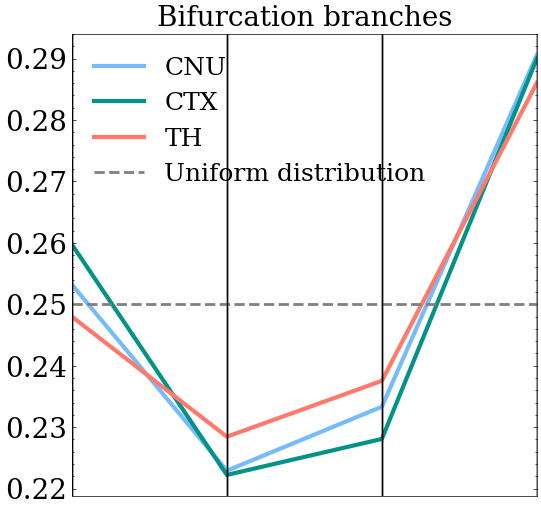

In [76]:
split_num=4
topath_f='/Users/jiangshengdian/Desktop/Daily/PhD_project/Platform/bouton/all_bouton_branch_data_split_4.csv'
if os.path.exists(topath_f):
    split_feas=['S'+str(split_num-x) for x in np.arange(split_num)]
    all_ana_data=pd.read_csv(topath_f,index_col=['brindex'])
    all_ana_data=all_ana_data[all_ana_data.tip_br==0].copy()
    ana_stypes_dis=pd.DataFrame(columns=split_feas)
    for stype in ana_stypes:
        ana_stype_df=all_ana_data[all_ana_data.stype==stype].copy()
        if stype=='SSp':
            ana_stype_df=all_ana_data[all_ana_data.stype.isin(ssp_regions)]
        ana_stypes_dis.loc[stype,:]=ana_stype_df[split_feas].mean()
ana_stypes_dis.loc[ana_stypes_dis.index.isin(cnu_stypes),'brain_region']='CNU'
ana_stypes_dis.loc[ana_stypes_dis.index.isin(ctx_stypes),'brain_region']='CTX'
ana_stypes_dis.loc[ana_stypes_dis.index.isin(th_stypes),'brain_region']='TH'
ana_stypes_dis_show=ana_stypes_dis.groupby(['brain_region']).mean().copy()
ana_stypes_dis_show.reset_index(inplace=True)
# ana_stypes_dis_avg=
ana_stypes_dis_avg=pd.DataFrame(columns=split_feas)
ana_stypes_dis_avg.loc['avg_ratio',split_feas]=1/split_num
ana_stypes_dis_avg.loc['avg_ratio','type']='Uniform distribution'
# Plot
fig=plt.figure(figsize=(6,6),dpi=100)
ax=plt.subplot(111)
parallel_coordinates(ana_stypes_dis_show, 'brain_region', color=bcolors,linewidth=3)
parallel_coordinates(ana_stypes_dis_avg, 'type', color='grey',linewidth=2,linestyle='--')
# ax.plot(x=1+np.arange(len(split_feas)),y=np.ones(len(split_feas))*0.25)
ax.tick_params(axis='x',labelsize=18)
ax.tick_params(axis='y',labelsize=20)
ax.yaxis.set_major_locator(MaxNLocator(8))
# Lighten borders
# plt.gca().spines["top"].set_alpha(0)
# plt.gca().spines["bottom"].set_alpha(.3)
# plt.gca().spines["right"].set_alpha(0)
# plt.gca().spines["left"].set_alpha(.3)
plt.xticks([])
plt.legend(fontsize=18)
# plt.title('Parallel Coordinated of Diamonds', fontsize=22)
# plt.grid(alpha=0.6)
plt.title('Bifurcation branches',fontsize=20)
# ax.set_axis_off()
# plt.ylim([0.2,0.35])
plt.show()  
fig.savefig('./figs/bouton_distribution_in_branch_bif.png',dpi=300)